In [1]:
import sys,os,operator

class NullWriter(object):
    def write(self, arg):
        pass

class DevNull:
    def write(self, msg):
        pass
    
oldstderr = sys.stderr
oldstdout = sys.stdout

sys.path.append('..')

import cobra,cameo,escher,pandas as pd,timeit,time,matplotlib.pyplot as plt,numpy as np,copy

from cameo import fba
from cameo import pfba
from excel_read import read_excel
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("bmh")

%matplotlib notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.precision = 10

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: goldenrod' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the minimum in a Series ligthblue.
    '''
    is_min = s == s.min()
    return ['background-color: blue' if v else '' for v in is_min]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, green otherwise.
    """
    color = 'red' if val < 0 else 'green'
    return 'background-color: %s' % color



match_list = {"Alanine" : "EX_ala(e)",
              "Arginine" : "EX_arg(e)",
              'Asparagine' : "EX_asn(e)",
              'Aspartic Acid' : "EX_asp(e)",
              'Ca pantothenate' : "None",
              'CaCl2' : "None",
              'Cholesterol' : 'EX_clr(e)',
              'Choline chloride' : 'EX_choline(e)',
              'CuSO4' : "None",
              'Cysteine' : 'EX_cys(e)',
              'FeSO4' : "None",
              'Glacial acetic acid' : "None",
              'Glutamate' : 'EX_glu-L(e)', 
              'Glutamine' : 'EX_gln-L(e)',
              'Glycine' : 'EX_gly(e)', 
              'Histidine' : 'EX_his(e)',
              'Inosine' : 'EX_i(e)',
              'Isoleucine' : 'EX_ile(e)',
              'KH2PO4' : "None",
              'Leucine' : 'EX_leu(e)',
              'Lysine' : 'EX_lys(e)',
              'Methionine' : 'EX_met(e)',
              'MgSO4' : "None",
              'MnCl2' : "None",
              'Myo-inositol' : 'EX_ins(e)',
              'NaHCO3' : "None",
              'Nicotinic acid' : "None",
              'Nipagin' : "None",
              'Phenylalanine' : 'EX_phe(e)',
              'Proline' : 'EX_pro(e)',
              'Propionic acid' : "None",
              'Riboflavin' : 'EX_RIBFLV(e)',
              'Serine' : 'EX_ser(e)',
              'Sodium folate' : "None",
              'Sucrose' : 'EX_sucr',
              'Thiamine' : "None",
              'Threonine' : 'EX_thr(e)',
              'Tryptophan' : 'EX_trp(e)',
              'Tyrosine' : 'EX_tyr(e)',
              'Uridine' : 'EX_urd(e)',
              'Valine' : 'EX_val(e)',
              'Water' : "None",
              'ZnSO4' : "None",
              'biotine' : "None",
              'pyridoxine' : "None"}


############# 
Graph for ATPM
0.0
0.49
0.99
1.49
1.99
2.49
2.99
3.49
3.99
4.49
4.99
5.49
5.99
6.49
6.99
7.49
7.99
8.49
8.99
9.49
9.99
Time elapsed: 27min 52sec
                 0      1
0     0.0879946357   0.00
1     0.0879946357   0.00
2     0.0879946357   0.01
3     0.0879946357   0.02
4     0.0879946357   0.03
5     0.0879946357   0.04
6     0.0879946357   0.05
7     0.0879946357   0.06
8     0.0879946357   0.07
9     0.0879946357   0.08
10    0.0879946357   0.09
11    0.0879946357   0.10
12    0.0879946357   0.11
13    0.0879946357   0.12
14    0.0879946357   0.13
15    0.0879946357   0.14
16    0.0879946357   0.15
17    0.0879946357   0.16
18    0.0879946357   0.17
19    0.0879946357   0.18
20    0.0879946357   0.19
21    0.0879946357   0.20
22    0.0879946357   0.21
23    0.0879946357   0.22
24    0.0879946357   0.23
25    0.0879946357   0.24
26    0.0879946357   0.25
27    0.0879946357   0.26
28    0.0879946357   0.27
29    0.0879946357   0.28
30    0.0879946357   0.29
31    0

u'\n[1] Da\u2010R\xe9, Caterina, et al.,\n    "UCP4C mediates uncoupled respiration in larvae of Drosophila melanogaster."\n    EMBO reports 15.5 (2014): 586-591.\n'

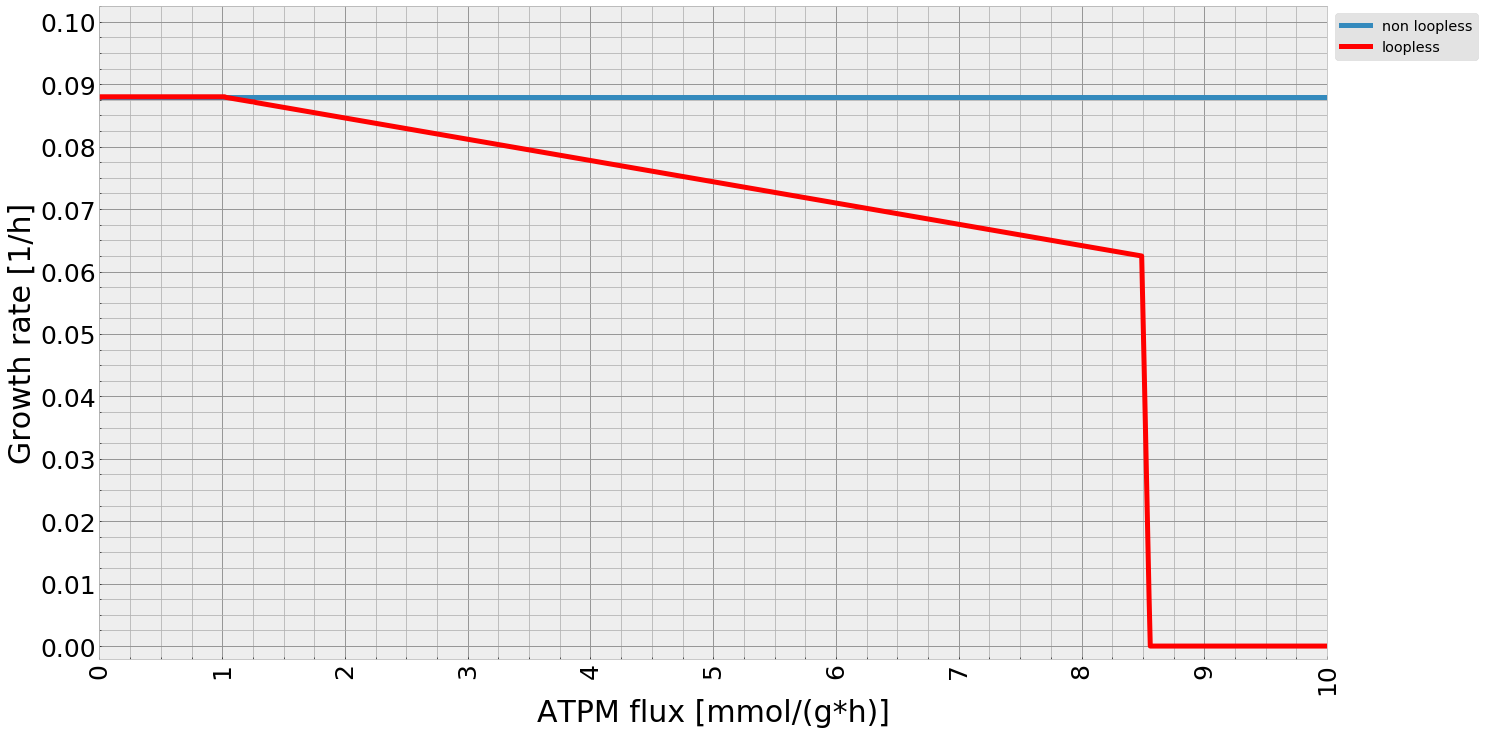

In [3]:
from cobra.flux_analysis.loopless import add_loopless, loopless_solution

######################################################
### Simulation ATPM loopless and non-loopless ###
######################################################

def ppp(reaction,label,points,end, start = 0, save = False, title = ""):
    start_time = timeit.default_timer()
    
    print ("\n"),"#"*(len("Graph for" + label)),("\n"),"Graph for", label
    if points < 1:
        points = 1
    
    sys.stdout = NullWriter() # disable output
    sys.stderr = DevNull()
    
    m = cameo.load_model("../FBA_Dmel.xml") #read sbml for cameo
    m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
    cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model
    #Oxygen uptake: (1600 pmol/min)/(0.2019mg)=0.47548 mmol/(g * h)
           #Calc. oxygen uptake based on data from Da‐Ré et al. [1]
    m_loopless.reactions.get_by_id("EX_o2").lower_bound = -0.47548  
    m_loopless.reactions.get_by_id("EX_o2").upper_bound = -0.47548 
    m.reactions.get_by_id("EX_o2").lower_bound = -0.47548 
    m.reactions.get_by_id("EX_o2").upper_bound = -0.47548 
    
    y_max = max([fba(m).objective_value, fba(m_loopless).objective_value])
    
    sys.stderr = oldstderr
    sys.stdout = oldstdout # enable output
    
    growth = []
    growth_ll = []
    growth_ll_alt = []
    meta = []
    meta_alt = []

    rnd = 0 #only counter
    rnd2 = 0 #only counter
    linspace = np.arange(start,end+(float(end)/points),(float(end)/points))
    if np.sign(start) != np.sign(end):
        linspace = np.sort(np.append(linspace,0))

    for i in linspace:
    
        rnd2 += 1 
        if rnd2 > rnd:
            rnd += 50
            print i
    
        m.reactions.get_by_id(reaction).lower_bound = i
        m.reactions.get_by_id(reaction).upper_bound = i
        m_loopless.reactions.get_by_id(reaction).upper_bound = i
        m_loopless.reactions.get_by_id(reaction).lower_bound = i
        meta += [i]
    
        try: # to avoid infeasable solutions
            fba_result = fba(m) #fba result of the model
            growth += [fba_result.objective_value]
        except: # if infeasable, add growth rate of 0
            growth += [0]
        
        try: # to avoid infeasable solutions
            fba_result_loopless = fba(m_loopless) #fba result of the loopless model
            growth_ll += [fba_result_loopless.objective_value]#.objective_value]
        except: # if infeasable, add growth rate of 0
            growth_ll += [0]

###############################################################
    fig,ax = plt.subplots(figsize=(22,12))
    
    plt.plot(meta,growth, label='non loopless',linewidth=5)
    plt.plot(meta,growth_ll, label='loopless',color="red",linewidth=5)
    
    plt.title(title, size= 30)
    plt.xlabel("%s flux [mmol/(g*h)]" % label, size= 30)
    plt.ylabel("Growth rate [1/h]", size= 30)
    
    plt.yticks(np.arange(0,0.102,.01), fontsize = 25)
    plt.xticks(np.arange(start,end+.1,1), fontsize = 25)
    
    plt.ylim(0-0.002,0.101)
    plt.xlim(start-(start*0.0),end+(end*0.00))
    
    if np.sign(start) != np.sign(end) and start != 0 and end != 0:
        plt.axvline(x=0,color="black", alpha=0.4)
    
    plt.legend(bbox_to_anchor=(1.001, 1), loc=2, fontsize='x-large').get_frame().set_facecolor('#DCDCDC')
    
    minor_ticks = np.arange(0,0.105,0.0025)
    minor_ticks_x = np.arange(start,end,0.25)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.grid(b=True, which="minor",ls="-",linewidth=.8)
    
    plt.grid(color='black', linestyle='-', linewidth=.8)
    if save is True:
        timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
        
        if not os.path.exists("ppp_plots"):
            os.makedirs("ppp_plots")
        
        plt.savefig('ppp_plots/ppp_%s_%s.png' % (reaction, timestr), bbox_inches='tight')
        
    elapsed = timeit.default_timer() - start_time
    time_e = ('{0:02.0f}min {1:02.0f}sec'.format(*divmod(elapsed, 60)))
    print "Time elapsed: "+time_e
    solution = zip(growth,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
    solution = zip(growth_ll,linspace)
    print pd.DataFrame(solution,).sort_values(by=1, ascending=1)
    
#########################################################################################################################

ppp(reaction = "ATPM",
    label = "ATPM",
    points = 1000,
    end = 10,
    start = 0,
    save = False)
u"""
[1] Da‐Ré, Caterina, et al.,
    "UCP4C mediates uncoupled respiration in larvae of Drosophila melanogaster."
    EMBO reports 15.5 (2014): 586-591.
"""